In [1]:
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install random
#!pip3 install scipy
#!pip3 install matplotlib

import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline

# Problem definition

To help restaurant owners reopen their businesses during the COVID-19 pandemic, the government created a generalised capacity risk index (CRI) to help owners understand the how risky it is to open up their indoor and outdoor seating areas.

The CRI is defined as follows:

$CRI = 4x_1^2 - 4x_1^4 + x_1^{6/3} +x_1x_2 - 4x_2^2 + 4x_2^4$

Where:

$x_1 = $Proportion of indoor seating available

$x_2 = $Proportion of outdoor seating available

Mary, a local restaurant owner wants to reopen her restaurant with as little risk as possible. She understands however that in order to give her staff worthwhile hours she will have to open up at least 10% of her indoor seating capacity and 25% of her outdoor seating capacity.

What is the safest way (according to the CRI) for Mary to reopen her business?

# Formulate as Non-linear programming problem 

With the CRI definition above and considering Mary wants to minimise the risk, we can define the objective function as follows:

Min $z = 4x_1^2 - 4x_1^4 + x_1^{6/3} +x_1x_2 - 4x_2^2 + 4x_2^4$

Subject to:

$x_1 >= 0.1$

$x_2 += 0.25$

$x_1, x_2 <=1$

# Plot problem

Before we go ahead and solve the problem lets plot our objective function and its constraints to understand if there is any issues with local/global minima and what sort of solution we should expect.

In this you will see that there is a local minimum at roughly $x_1 = 1$ and $x_2 = 0.6$, however the global minimum (within our constraints) is placed at about $x_1 = 0.1$ and $x_2 = 0.7$.

<ipython-input-2-67c35ee5e021>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


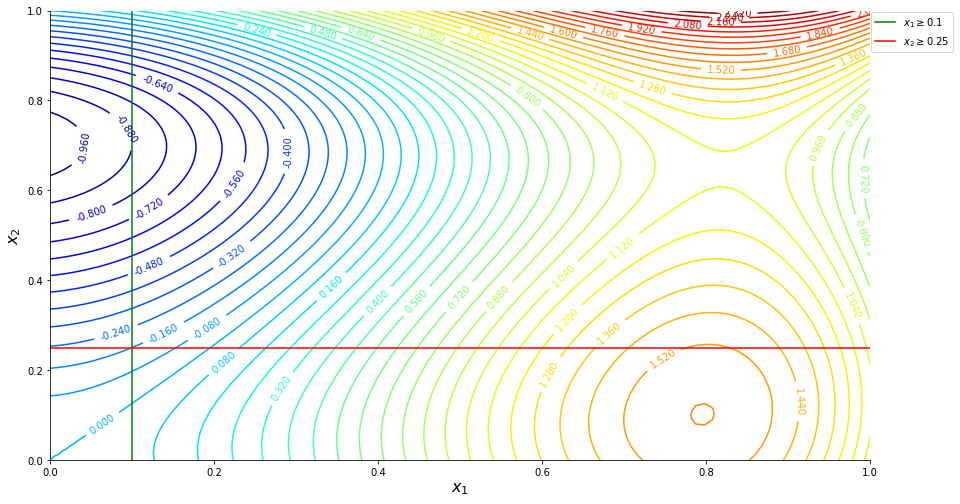

In [2]:
objective_function = lambda x: (4*x[0]**2) - (4*x[0]**4) + (x[0]**(6/3) + (x[0]*x[1]) - (4*x[1]**2) + (4*x[1]**4))

X_1 = np.linspace(0,1, 100)
X_2 = np.linspace(0,1, 100)
X_1, X_2 = np.meshgrid(X_1, X_2)
Z = objective_function((X_1, X_2))

#Contour plot
fig, ax = plt.subplots()
fig.set_size_inches(14.7, 8.27)

cs = ax.contour(X_1, X_2, Z, 50, cmap='jet')
plt.clabel(cs, inline=1, fontsize=10) # plot objective function

plt.axvline(0.1, color='g', label=r'$x_1 \geq 0.1$') # constraint 1
plt.axhline(0.25, color='r', label=r'$x_2 \geq 0.25$') # constraint 2
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

# tidy up
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.show()

# Solve problem using multi-start algorithim

## Create a function to generate starting points

We will use the function below to generate a tuple of starting points within the feasible range for this problem

In [3]:
def geneate_starting_points(number_of_points):
    '''
    number_of_points: how many points we want to generate
    
    returns a list of starting points
    '''
    starting_points = []
    
    for point in range(number_of_points):
        
        starting_points.append((random.random(), random.random()))
        
    return starting_points

## Define our objective and constraints

In [4]:
# define our objective function
objective_function = lambda x: (4*x[0]**2) - (4*x[0]**4) + (x[0]**(6/3) + (x[0]*x[1]) - (4*x[1]**2) + (4*x[1]**4))

# define our constraints
# note that since we have >= constraints we use the 'ineq' constaint type
cons = [
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.1}, # indoor seating >= 0.1
    {'type': 'ineq', 'fun': lambda x: x[1] - 0.25} # outdoor seating >= 0.25
]

# define boundaries
boundaries = [(0,1), (0,1)]

## Bring it all together and implement multi-start optimisation to solve problem

In [5]:
# generate a list of N potential starting points
starting_points = geneate_starting_points(50)

first_iteration = True
for point in starting_points:
    # for each point run the algorithim
    res = minimize(
        objective_function,
        [point[0], point[1]],
        method='SLSQP',
        bounds=boundaries,
        constraints=cons
    )
    # first iteration always gonna be the best so far
    if first_iteration:
        better_solution_found = False
        best = res
    else:
        # if we find a better solution, lets use it
        if res.success and res.fun < best.fun:
            better_solution_found = True
            best = res
            
# print results if algorithim was successful
if best.success:
    print(f"""Optimal solution found:
      -  Proportion of indoor seating to make available: {round(best.x[0], 3)}
      -  Proportion of outdoor seating to make available: {round(best.x[1], 3)}
      -  Risk index score: {round(best.fun, 3)}""")
else: 
    print("No solution found to problem")

Optimal solution found:
      -  Proportion of indoor seating to make available: 0.1
      -  Proportion of outdoor seating to make available: 0.701
      -  Risk index score: -0.88
